In [132]:
# Bibliothèques générales
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialisation de Spark
import findspark
findspark.init()

# Bibliothèques PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [134]:
import os
os.environ["HADOOP_HOME"] = "C:/PySpark"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["HADOOP_HOME"], "bin")
spark = SparkSession.builder \
    .appName("ModelTraining") \
    .config("spark.hadoop.io.native.lib.available", "false") \
    .config("spark.hadoop.io.file.access.check", "false") \
    .getOrCreate()

In [136]:
# Charger les fichiers CSV
data = spark.read.csv("twitter_training.csv", header=False, inferSchema=True)
validation = spark.read.csv("twitter_validation.csv", header=False, inferSchema=True)

# Définir et appliquer les noms de colonnes
columns = ['id', 'Company', 'Label', 'Text']
for i, col_name in enumerate(columns):
    data = data.withColumnRenamed(f"_c{i}", col_name)
    validation = validation.withColumnRenamed(f"_c{i}", col_name)

# Supprimer les lignes sans texte
data = data.dropna(subset=["Text"])
validation = validation.dropna(subset=["Text"])


In [138]:
# Encodage des étiquettes textuelles
label_indexer = StringIndexer(inputCol="Label", outputCol="Label2")
label_indexer_model = label_indexer.fit(data)
data = label_indexer_model.transform(data)
validation = label_indexer_model.transform(validation)

# Afficher la correspondance des étiquettes
print("Label Mapping:")
for index, label in enumerate(label_indexer_model.labels):
    print(f"Index {index} --> Label '{label}'")


Label Mapping:
Index 0 --> Label 'Negative'
Index 1 --> Label 'Positive'
Index 2 --> Label 'Neutral'
Index 3 --> Label 'Irrelevant'


In [90]:
def clean_text(df, inputCol="Text", outputCol="Text"):
    df = df.withColumn(outputCol, regexp_replace(col(inputCol), r'https?://\S+|www\.\S+|\S+\.com\S+|youtu\.be/\S+', ''))
    df = df.withColumn(outputCol, regexp_replace(col(outputCol), r'(@|#)\w+', ''))
    df = df.withColumn(outputCol, lower(col(outputCol)))
    df = df.withColumn(outputCol, regexp_replace(col(outputCol), r'[^a-zA-Z\s]', ''))
    return df

data = clean_text(data)
validation = clean_text(validation)


In [92]:
from nltk.corpus import stopwords
import string

# Chargement et nettoyage des stopwords
stop_words = stopwords.words("english")
# Éventuellement, ajoute aussi la ponctuation
stop_words += list(string.punctuation)

# Pipeline
tokenizer = Tokenizer(inputCol="Text", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stop_words)
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features", vocabSize=10000, minDF=5)
lr = LogisticRegression(labelCol="Label2", featuresCol="features", maxIter=10)
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, lr])


In [94]:
data.cache()
data.count()

73996

In [95]:
model = pipeline.fit(data)
processed_data = model.transform(data)


In [98]:
processed_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Label2: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [100]:
processed_data.select("Text", "Label2", "prediction").show(20)


+--------------------+------+----------+
|                Text|Label2|prediction|
+--------------------+------+----------+
|im getting on bor...|   1.0|       1.0|
|i am coming to th...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im coming on bord...|   1.0|       1.0|
|im getting on bor...|   1.0|       1.0|
|im getting into b...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a coup...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
|so i spent a few ...|   1.0|       1.0|
| so i spent a few...|   1.0|       1.0|
|                 was|   1.0|       0.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la varlo...|   2.0|       2.0|
|rockhard la vita ...|   2.0|       2.0|
|live rock  hard m...|   2.0|       2.0|
|ihard like me rar...|   2.0|       2.0|
|that was the firs...|   1.0|       1.0|
|this was the firs...|   1.0|       1.0|
+--------------------+------+----------+
only showing top

In [118]:
model.write().overwrite().save("logistic_regression_model.pkl")


In [126]:
processed_validation = model.transform(validation)

Accuracy: 0.873
Confusion Matrix:


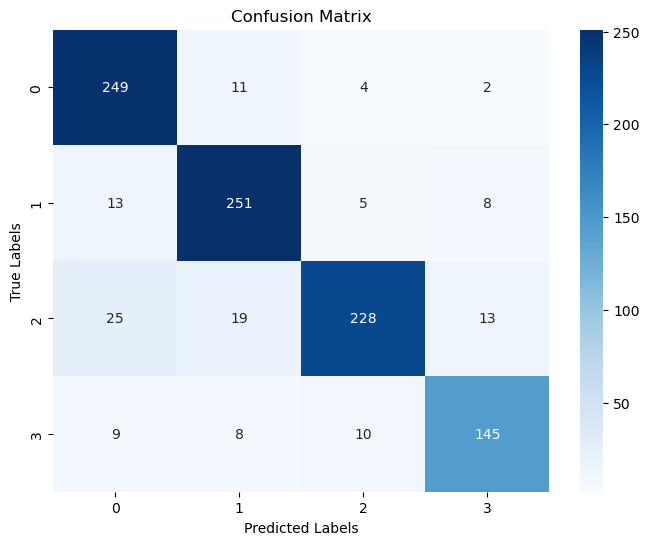

In [130]:
# Evaluate accuracy
from sklearn.metrics import confusion_matrix
evaluator = MulticlassClassificationEvaluator(labelCol="Label2", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(processed_validation)
print("Accuracy:", accuracy)

# --- Create a confusion matrix

# Convert Spark DataFrame to Pandas DataFrame
prediction_and_label_pd = processed_validation.select("prediction", "Label2").toPandas()

# Extract predicted labels and true labels
predicted_labels = prediction_and_label_pd["prediction"].tolist()
true_labels = prediction_and_label_pd["Label2"].tolist()

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()